In [16]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [17]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [18]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\train\other\other_0_5285.jpeg
Image class: other
Image height: 256
Image width: 256


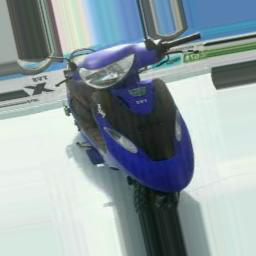

In [19]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

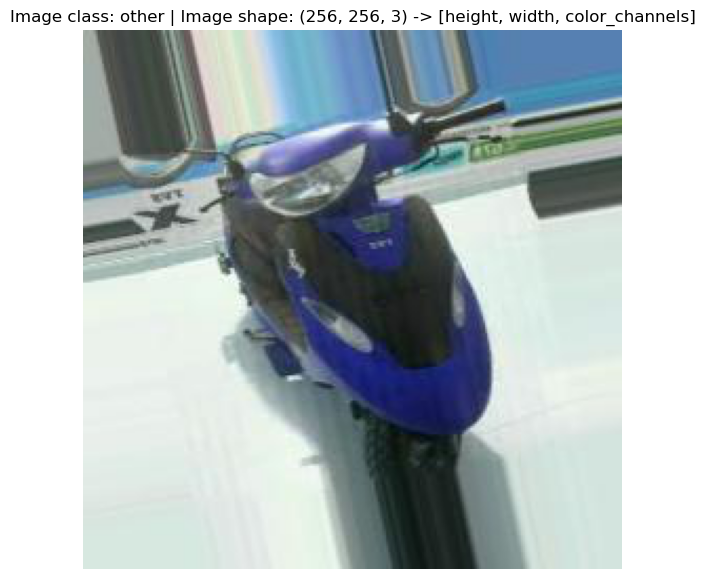

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

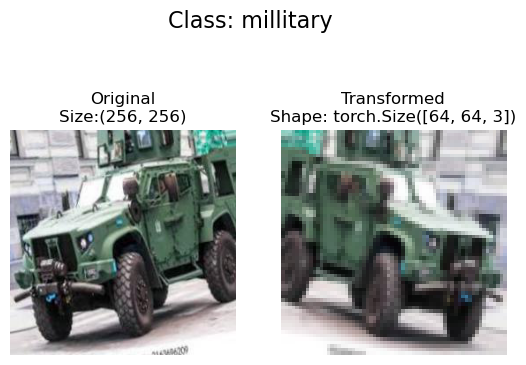

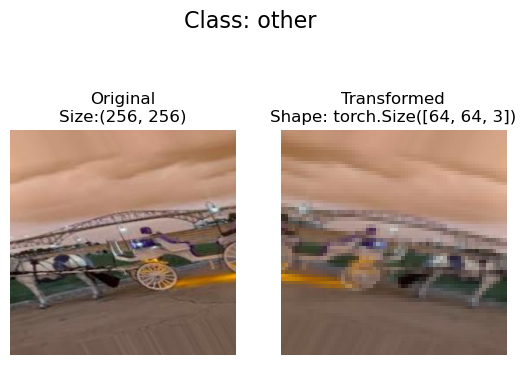

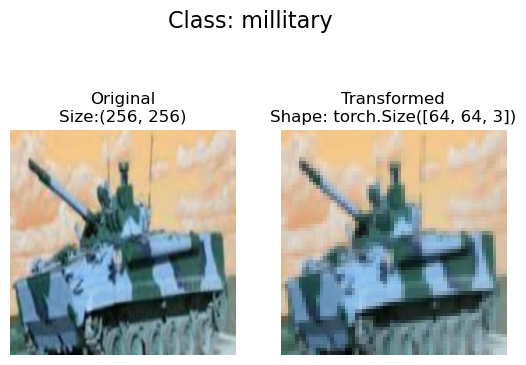

In [22]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [23]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [24]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [25]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [26]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1af6722a970>,
 <torch.utils.data.dataloader.DataLoader at 0x1af67526550>)

In [27]:
from helper_functions import set_seeds
set_seeds()

class MilitaryNormalClassModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [28]:
model_0=MilitaryNormalClassModel(input_shape=3,
                                 hidden_units=10,
                                 output_shape=len(classes)).to(device)

In [29]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time, test_step, train_step 

from timeit import default_timer as timer


train_time_start_model_0=timer()

epochs=10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_0,
                                          end=train_time_end_model_0,
                                          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.69000 | Train acc: 53.97%


 10%|█         | 1/10 [00:48<07:16, 48.54s/it]


Test loss: 0.6891, Test acc 54.2556
Epoch: 2
-------------
Train loss: 0.68926 | Train acc: 54.08%


 20%|██        | 2/10 [01:36<06:24, 48.02s/it]


Test loss: 0.6889, Test acc 54.1084
Epoch: 3
-------------
Train loss: 0.68892 | Train acc: 54.01%


 30%|███       | 3/10 [02:23<05:33, 47.70s/it]


Test loss: 0.6883, Test acc 54.1820
Epoch: 4
-------------
Train loss: 0.68779 | Train acc: 54.23%


 40%|████      | 4/10 [03:11<04:46, 47.75s/it]


Test loss: 0.6874, Test acc 54.1084
Epoch: 5
-------------
Train loss: 0.68643 | Train acc: 54.13%


 50%|█████     | 5/10 [03:59<03:58, 47.76s/it]


Test loss: 0.6850, Test acc 54.0838
Epoch: 6
-------------
Train loss: 0.68244 | Train acc: 54.08%


 60%|██████    | 6/10 [04:49<03:14, 48.66s/it]


Test loss: 0.6799, Test acc 56.9294
Epoch: 7
-------------
Train loss: 0.67325 | Train acc: 55.83%


 70%|███████   | 7/10 [05:38<02:25, 48.65s/it]


Test loss: 0.6653, Test acc 58.7520
Epoch: 8
-------------
Train loss: 0.65829 | Train acc: 60.70%


 80%|████████  | 8/10 [06:27<01:37, 48.73s/it]


Test loss: 0.6493, Test acc 62.4097
Epoch: 9
-------------
Train loss: 0.64430 | Train acc: 63.34%


 90%|█████████ | 9/10 [07:14<00:48, 48.19s/it]


Test loss: 0.6410, Test acc 62.9799
Epoch: 10
-------------
Train loss: 0.63647 | Train acc: 64.00%


100%|██████████| 10/10 [08:01<00:00, 48.20s/it]


Test loss: 0.6559, Test acc 61.3485

Train time on cuda: 481.958 seconds
